In [1]:
import pandas as pd
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot

from power_prediction.preprocess_data import get_data_retain_nan
from power_prediction.time_series_decomposition import df_to_prophet, fit_and_predict_prophet, get_start_and_end_dates_for_key, df_time_to_utc_plus_one

### Preparation

The target values of the project will be analyzed and predicted using `prophet`.
After prediction, the different seasonal components will be analyzed.

For the analysis, only the data with removed NaN values will be used, since it proved to be the best choice for Prophet

In [2]:
df = df_time_to_utc_plus_one(get_data_retain_nan())
df_prophet_ne5 = df_to_prophet(df, "Value_NE5")
df_prophet_ne7 = df_to_prophet(df, "Value_NE7")
df_prophet_netot = df_to_prophet(df, "NE_tot")

### Holidays

Since holidays can impact power consumption significantly, all holidays are added to a holidays DataFrame, which can be provided to Prophet for more accurate predictions.

In [3]:
holidays_start, holidays_end = get_start_and_end_dates_for_key(df, "Holiday")
df_holiday = pd.DataFrame({
    'holiday': [f'holiday_{i+1}' for i in holidays_start.index], 
    'ds': pd.to_datetime(holidays_start), 
    'lower_window': 0, 
    'ds_upper': pd.to_datetime(holidays_end)
})
df_holiday['upper_window'] = (df_holiday['ds_upper'] - df_holiday['ds']).dt.days
df_holiday

,holiday,ds,lower_window,ds_upper,upper_window
0,holiday_1,2015-01-01,0,2015-01-02 23:00:00,1
1,holiday_2,2015-04-03,0,2015-04-03 23:00:00,0
2,holiday_3,2015-04-05,0,2015-04-06 23:00:00,1
3,holiday_4,2015-04-13,0,2015-04-13 23:00:00,0
4,holiday_5,2015-05-01,0,2015-05-01 23:00:00,0
...,...,...,...,...,...
93,holiday_94,2024-05-01,0,2024-05-01 23:00:00,0
94,holiday_95,2024-05-09,0,2024-05-09 23:00:00,0
95,holiday_96,2024-05-19,0,2024-05-20 23:00:00,1
96,holiday_97,2024-08-01,0,2024-08-01 23:00:00,0


The same will also be done for school vacation

In [4]:
vacation_start, vacation_end = get_start_and_end_dates_for_key(df, "Vacation")
df_vacation = pd.DataFrame({
    'holiday': [f'vacation_{i+1}' for i in vacation_start.index], 
    'ds': pd.to_datetime(vacation_start), 
    'lower_window': 0, 
    'ds_upper': pd.to_datetime(vacation_end)
})
df_vacation['upper_window'] = (df_vacation['ds_upper'] - df_vacation['ds']).dt.days
df_vacation

,holiday,ds,lower_window,ds_upper,upper_window
0,vacation_1,2015-01-01,0,2015-01-03 23:00:00,2
1,vacation_2,2015-02-08,0,2015-02-21 23:00:00,13
2,vacation_3,2015-04-19,0,2015-05-02 23:00:00,13
3,vacation_4,2015-07-12,0,2015-08-15 23:00:00,34
4,vacation_5,2015-10-04,0,2015-10-17 23:00:00,13
5,vacation_6,2015-12-20,0,2016-01-02 23:00:00,13
6,vacation_7,2016-02-14,0,2016-02-27 23:00:00,13
7,vacation_8,2016-04-24,0,2016-05-07 23:00:00,13
8,vacation_9,2016-07-17,0,2016-08-20 23:00:00,34
9,vacation_10,2016-10-09,0,2016-10-22 23:00:00,13


Lastly, covid lockdowns in Switzerland are treated as holidays

In [5]:
lockdown_start, lockdown_end = get_start_and_end_dates_for_key(df, "Corona")
df_lockdown = pd.DataFrame({
    'holiday': [f'lockdown_{i+1}' for i in lockdown_start.index], 
    'ds': pd.to_datetime(lockdown_start), 
    'lower_window': 0, 
    'ds_upper': pd.to_datetime(lockdown_end)
})
df_lockdown['upper_window'] = (df_lockdown['ds_upper'] - df_lockdown['ds']).dt.days
df_lockdown


,holiday,ds,lower_window,ds_upper,upper_window
0,lockdown_1,2020-03-18 01:00:00,0,2020-06-06 01:00:00,80
1,lockdown_2,2021-01-18 01:00:00,0,2021-03-04 01:00:00,45


A chosen subset of these DataFrames is now concatenated. In this way the influence of a single group of holidays or multiple groups combined on the time series can be seen.

In [6]:
df_holiays = pd.concat((df_lockdown, df_holiday, df_vacation))
df_holiays

,holiday,ds,lower_window,ds_upper,upper_window
0,lockdown_1,2020-03-18 01:00:00,0,2020-06-06 01:00:00,80
1,lockdown_2,2021-01-18 01:00:00,0,2021-03-04 01:00:00,45
0,holiday_1,2015-01-01 00:00:00,0,2015-01-02 23:00:00,1
1,holiday_2,2015-04-03 00:00:00,0,2015-04-03 23:00:00,0
2,holiday_3,2015-04-05 00:00:00,0,2015-04-06 23:00:00,1
...,...,...,...,...,...
36,vacation_37,2023-07-16 00:00:00,0,2023-08-19 23:00:00,34
37,vacation_38,2023-10-08 00:00:00,0,2023-10-21 23:00:00,13
38,vacation_39,2023-12-24 00:00:00,0,2024-01-06 23:00:00,13
39,vacation_40,2024-04-21 00:00:00,0,2024-05-04 23:00:00,13


# Fit and Forecast

All three target variables will be separately fit to the Prophet model. In order to do a component analysis, one has to make a forecast with Prophet. For this forecast, a period of one year is chosen.

#### NE5

In [7]:
prophet_ne5 = Prophet(holidays=df_holiays)
forecast_ne5 = fit_and_predict_prophet(prophet_ne5, df_prophet_ne5)

14:06:55 - cmdstanpy - INFO - Chain [1] start processing
14:13:15 - cmdstanpy - INFO - Chain [1] done processing


#### Forecast plot

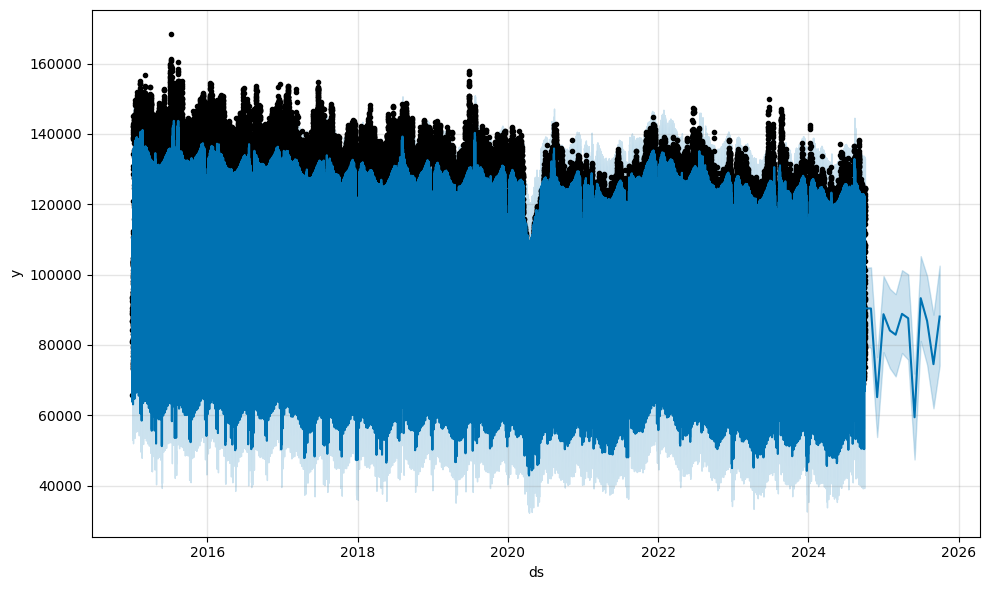

In [8]:
fig_ne5 = prophet_ne5.plot(forecast_ne5)

#### Changepoints in analysis

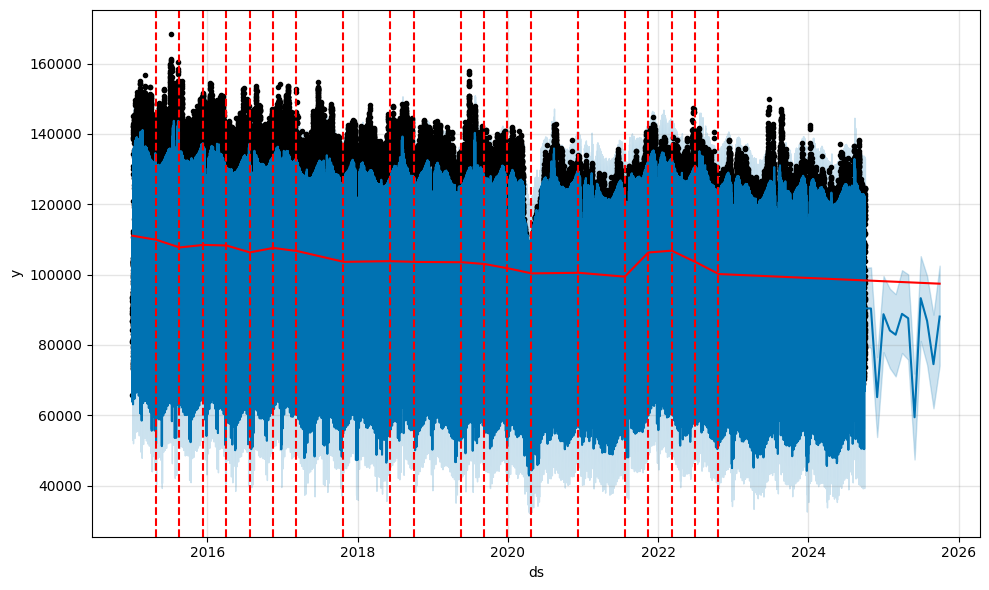

In [9]:
add_changepoints_to_plot(fig_ne5.gca(), prophet_ne5, forecast_ne5)
fig_ne5

#### Components plot

Text(0.5, 0.98, 'Target: NE5')

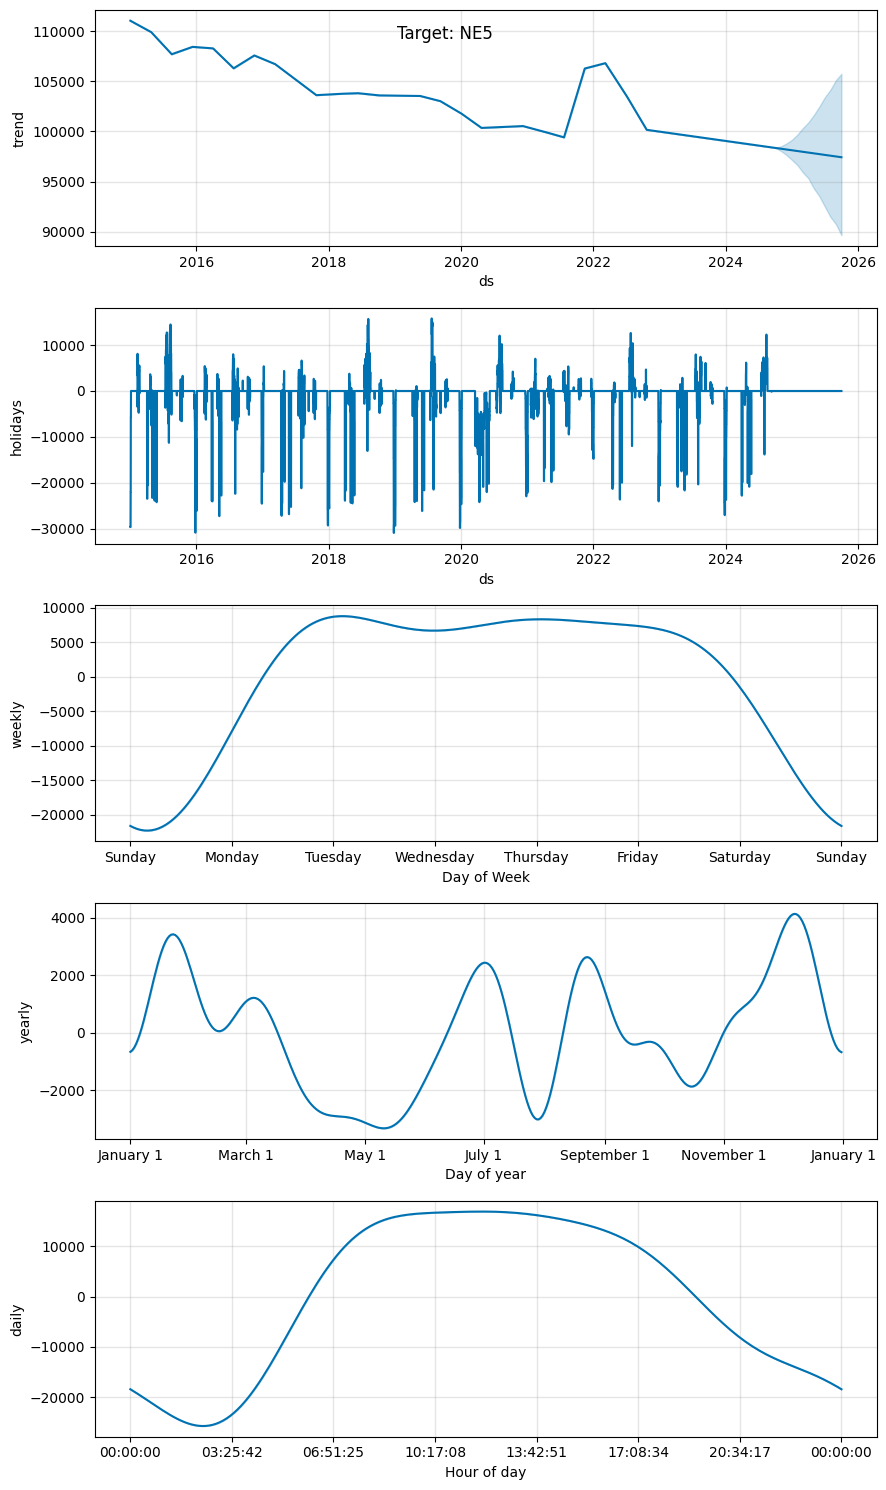

In [10]:
plot_ne5 = prophet_ne5.plot_components(forecast_ne5)
plot_ne5.suptitle("Target: NE5")

### NE7

In [11]:
prophet_ne7 = Prophet(holidays=df_holiays)
forecast_ne7 = fit_and_predict_prophet(prophet_ne7, df_prophet_ne7)

14:15:36 - cmdstanpy - INFO - Chain [1] start processing
14:20:26 - cmdstanpy - INFO - Chain [1] done processing


#### Forecast plot

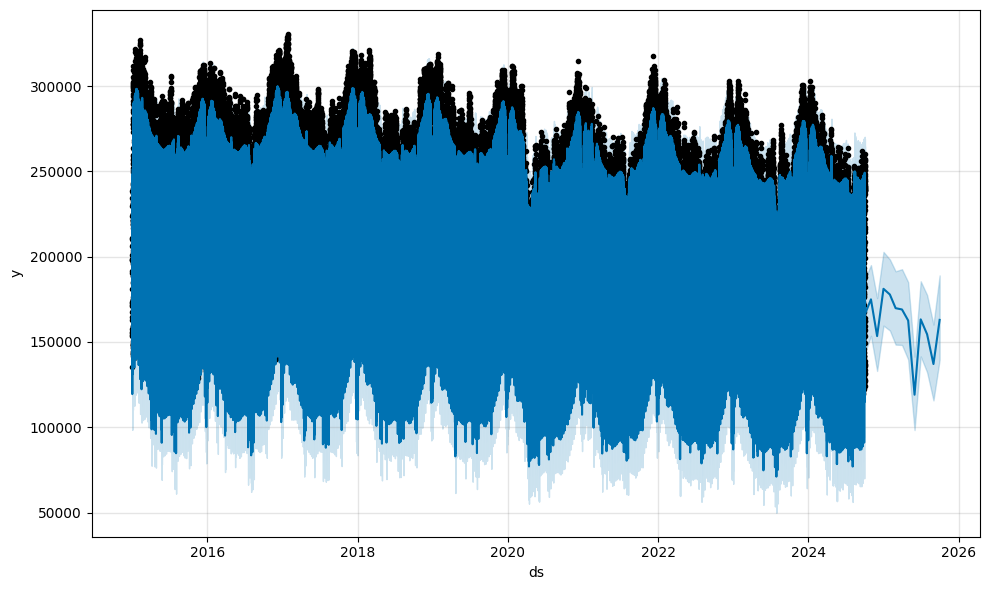

In [12]:
fig_ne7 = prophet_ne7.plot(forecast_ne7)

#### Changepoints in analysis

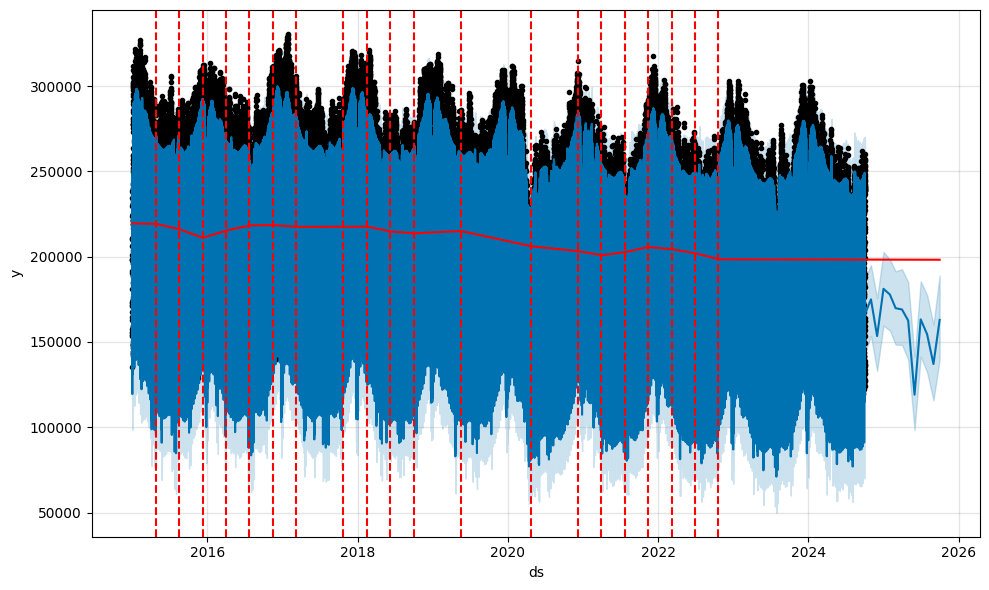

In [13]:
add_changepoints_to_plot(fig_ne7.gca(), prophet_ne7, forecast_ne7)
fig_ne7

#### Components plot

Text(0.5, 0.98, 'Target: NE7')

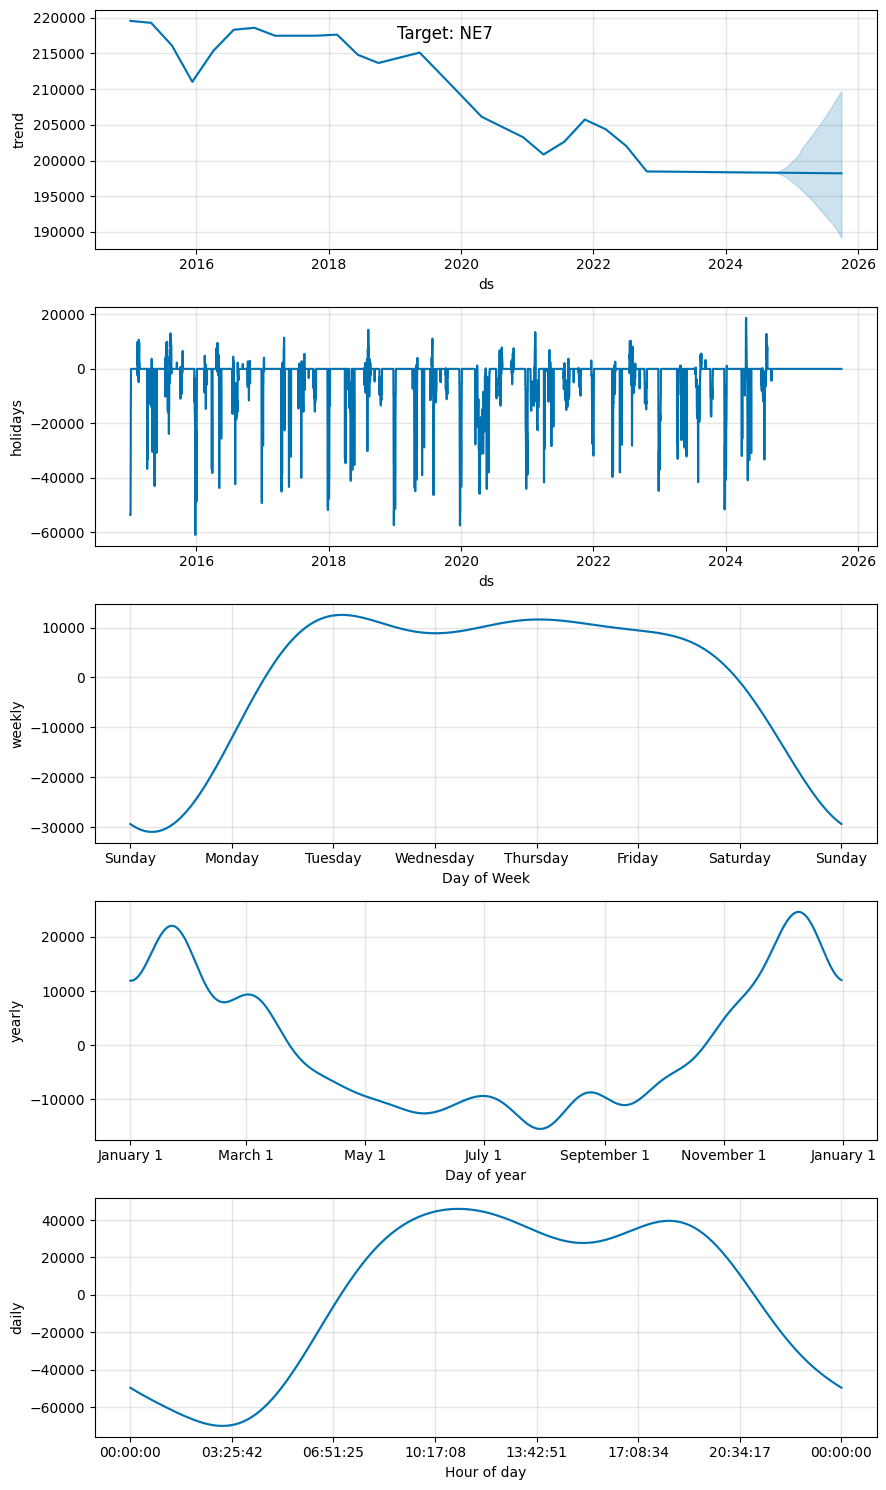

In [14]:
plot_ne7 = prophet_ne7.plot_components(forecast_ne7)
plot_ne7.suptitle("Target: NE7")

### NE_TOT

In [15]:
prophet_ne_tot = Prophet(holidays=df_holiays)
forecast_ne_tot = fit_and_predict_prophet(prophet_ne_tot, df_prophet_netot)

14:22:19 - cmdstanpy - INFO - Chain [1] start processing
14:26:16 - cmdstanpy - INFO - Chain [1] done processing


#### Forecast plot

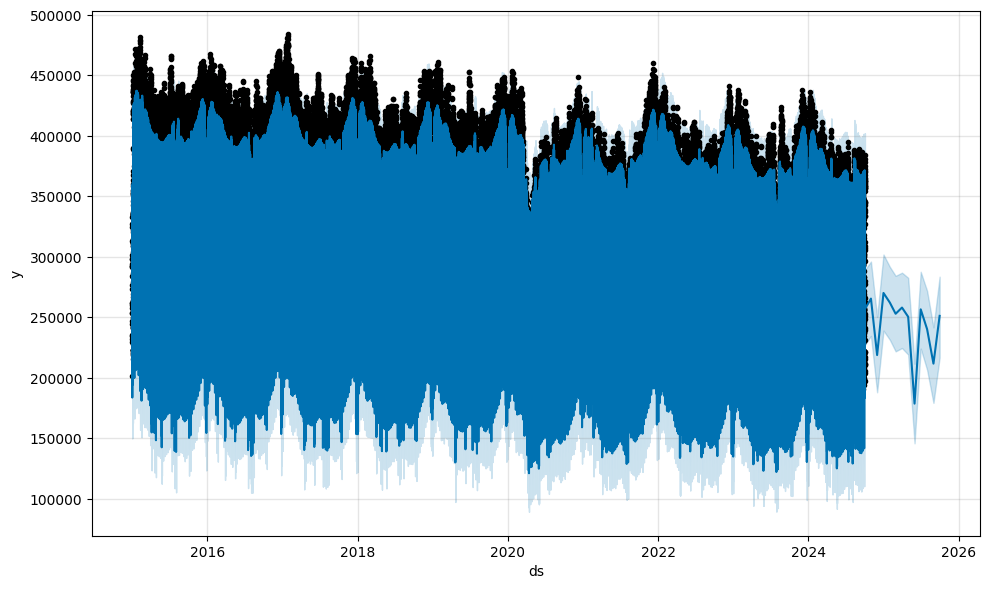

In [16]:
fig_ne_tot = prophet_ne_tot.plot(forecast_ne_tot)

#### Changepoints in analysis

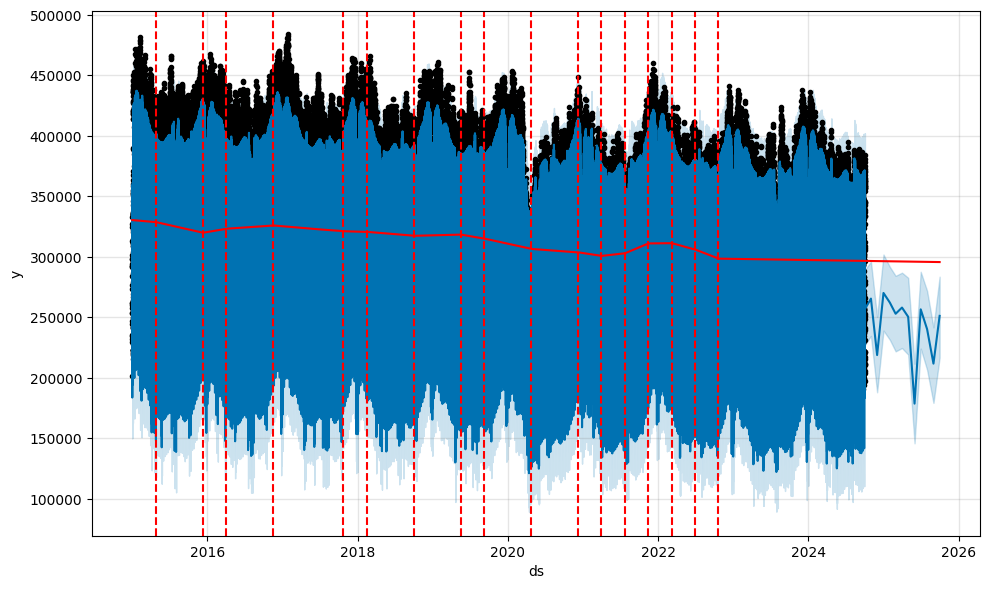

In [17]:
add_changepoints_to_plot(fig_ne_tot.gca(), prophet_ne_tot, forecast_ne_tot)
fig_ne_tot

#### Components plot

Text(0.5, 0.98, 'Target: NE_TOT')

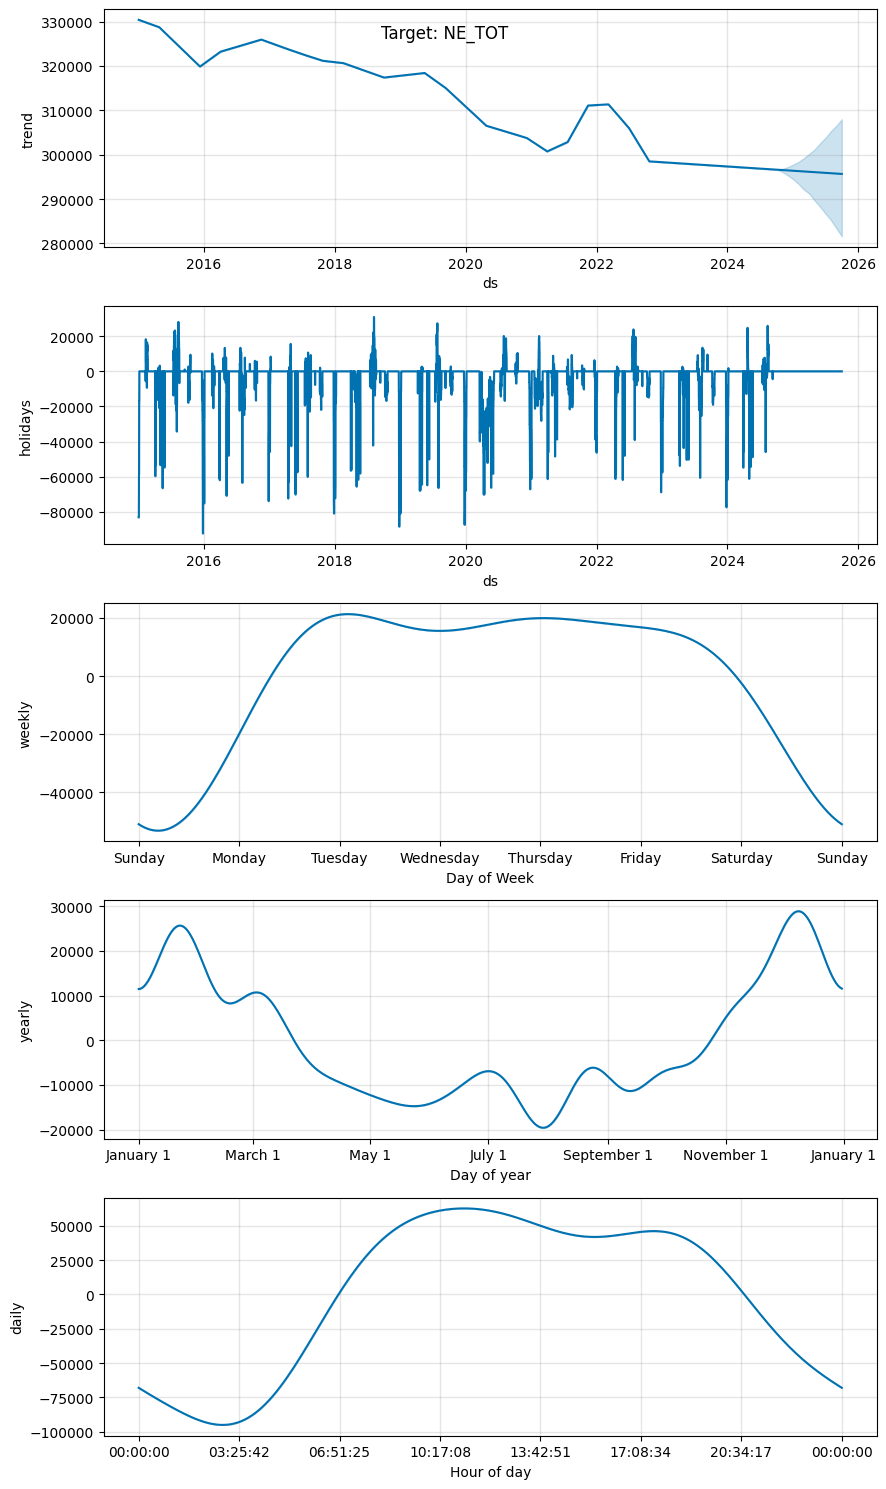

In [18]:
plot_ne_tot = prophet_ne_tot.plot_components(forecast_ne_tot)
plot_ne_tot.suptitle("Target: NE_TOT")

## Store remainder data

In [19]:
df_remainders = df.copy()

In [20]:
df_remainders.head()

,Date,Value_NE5,Value_NE7,Hr [%Hr],RainDur [min],StrGlo [W/m2],T [°C],WD [°],WVs [m/s],WVv [m/s],...,Vacation,Holiday,Date_format,Year,Month,Day,Hour,Weekday,NE_tot,Corona
0,2015-01-01 00:00:00,65674.7507,135628.059644,89.25,0.0,0.02,-2.09,20.41,1.40,1.40,...,1.0,1.0,2014-12-31 23:00:00+00:00,2014,12,31,23,3,201302.810344,0
1,2015-01-01 01:00:00,88747.5885,172742.750946,90.47,0.0,0.01,-2.48,353.85,0.61,0.60,...,1.0,1.0,2015-01-01 00:00:00+00:00,2015,1,1,0,4,261490.339446,0
2,2015-01-01 02:00:00,86864.5321,173541.200194,89.45,0.0,0.02,-2.46,21.48,1.31,1.31,...,1.0,1.0,2015-01-01 01:00:00+00:00,2015,1,1,1,4,260405.732294,0
3,2015-01-01 03:00:00,84158.7339,162802.863240,89.20,0.0,0.02,-2.63,12.22,1.70,1.66,...,1.0,1.0,2015-01-01 02:00:00+00:00,2015,1,1,2,4,246961.597140,0
4,2015-01-01 04:00:00,81133.3041,154123.513780,89.56,0.0,0.02,-2.77,8.30,1.23,1.21,...,1.0,1.0,2015-01-01 03:00:00+00:00,2015,1,1,3,4,235256.817880,0


In [21]:
df_remainders.drop(["Value_NE5", "Value_NE7", "NE_tot", "Vacation", "Holiday", "Date_format", "Year", "Month", "Day", "Hour", "Weekday", "Corona"], axis=1, inplace=True)

In [22]:
df_remainders = df_remainders.merge(pd.DataFrame({"Date": forecast_ne5["ds"], "NE5_remainder": df["Value_NE5"] - forecast_ne5["yhat"], "NE5_yhat": forecast_ne5["yhat"]}), on="Date", how="left")
df_remainders = df_remainders.merge(pd.DataFrame({"Date": forecast_ne7["ds"], "NE7_remainder": df["Value_NE7"] - forecast_ne5["yhat"], "NE7_yhat": forecast_ne7["yhat"]}), on="Date", how="left")
df_remainders = df_remainders.merge(pd.DataFrame({"Date": forecast_ne_tot["ds"], "NETOT_remainder": df["NE_tot"] - forecast_ne_tot["yhat"], "NETOT_yhat": forecast_ne_tot["yhat"]}), on="Date", how="left")

In [24]:
df_remainders.to_csv("./data/time_decomposition_remainder_data.csv")